# Malaria Parasite Detection Using Ensemble Learning in TF-Keras

## Loading the cell image data

Ensemble learning combines the predictions of multiple models to improve the prediction accuracy.

There are several ways to perform ensemble learning, and a reasonable summary is available on https://en.wikipedia.org/wiki/Ensemble_learning. Simply speaking, there are two major classes of ensemble learning:
- Bagging: fit independent models and then average their predictions
- Boosting: fit several models sequencially and then average their predictions

Dataset: https://www.tensorflow.org/datasets/catalog/malaria

In [ ]:
!wget "https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip"

In [ ]:
!unzip "/content/cell_images.zip"

In [ ]:
import statistics
import os
import glob
import numpy as np
import pandas as pd
from concurrent import futures
import threading
import shutil

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

import sklearn
import itertools
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

Next, we load the data. 
- File names are obtained using the glob module.
- Create a data frame object for infected and healthy cell images
- Check how many of each class are there in the sample; we should be close to 50/50

In [ ]:
infected = '/content/cell_images/Parasitized'
healthy = '/content/cell_images/Uninfected'

infected_files = glob.glob(infected+'/*.png')
healthy_files = glob.glob(healthy+'/*.png')

files_df = pd.DataFrame({
    'img': infected_files + healthy_files,
    'malaria': [1] * len(infected_files) + [0] * len(healthy_files)
})

files_df = files_df.sample(frac=1, random_state=42).reset_index(drop=True)

files_df['malaria'].value_counts()

1    13779
0    13779
Name: malaria, dtype: int64

## Split Data Into Folders for Imagedatagenerator

In [ ]:
root_dir = '/content/cell_images'
classes_dir = ['/Parasitized', '/Uninfected']

val_ratio = 0.30
test_ratio = 0.10

for cls in classes_dir:
    os.makedirs(root_dir +'/train' + cls)
    os.makedirs(root_dir +'/val' + cls)
    os.makedirs(root_dir +'/test' + cls)

    # Creating partitions of the data after shuffling
    src = '/content/cell_images' + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio + test_ratio)),
                                                               int(len(allFileNames)* (1 - test_ratio))])

    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test' + cls)



Total images:  13780
Training:  11023
Validation:  1379
Testing:  1378
Total images:  13780
Training:  11023
Validation:  1379
Testing:  1378


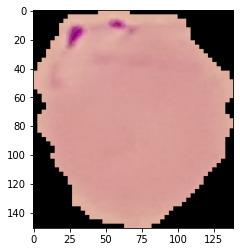

In [ ]:
img = mpimg.imread('/content/cell_images/test/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png') 
plt.imshow(img) 

In [ ]:
img.shape

(151, 139, 3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1/255.0,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     zoom_range=0.2,
                                     fill_mode = 'nearest')  
train_dir = "/content/cell_images/train"
train_dataset = train_gen.flow_from_directory(batch_size=64,
                                                 directory=train_dir,
                                                 shuffle=True,
                                                 color_mode = 'rgb',
                                                 target_size=(125, 125), 
                                                 class_mode='categorical')

validation_gen = ImageDataGenerator(rescale=1/255.0)
validation_dir = "/content/cell_images/val"
validation_dataset = validation_gen.flow_from_directory(batch_size=64,
                                                 directory=validation_dir,
                                                 shuffle=True,
                                                 color_mode = 'rgb',
                                                 target_size=(125, 125), 
                                                 class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = "/content/cell_images/test"
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(125, 125),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

Found 22044 images belonging to 2 classes.
Found 2758 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


## Deep Ensemble CNN

Time to start doing deep learning to predict the presence or absence of malaria in cell images.

We will be experimenting with a deep ensemble CNN which has the following architecture: 
* VGG19 - Xception - Average Layer


The Adam optimizer will be used with a learning rate of 0.0001.

In [ ]:
vgg19 = tf.keras.applications.VGG19(include_top=False, input_shape=(125,125,3), weights='imagenet')

for layer in vgg19.layers:
  layer.trainable = False

vgg19.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
______________________________________________________________

In [ ]:
vgg19_out = vgg19.get_layer('block3_pool').output

x = Conv2D(512, (3,3), kernel_initializer='he_uniform', bias_initializer='ones', 
           activation= tf.keras.layers.LeakyReLU(alpha = 0.24),padding = 'same')(vgg19_out)
x = BatchNormalization(momentum = 0.99)(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Dropout(0.5)(x)

x = Conv2D(512, (3,3), kernel_initializer='he_uniform', bias_initializer='zeros', 
           activation= tf.keras.layers.LeakyReLU(alpha = 0.24),padding = 'same')(x)
x = BatchNormalization(momentum = 0.99)(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)

x = Dense(256, activation= 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(0.2)(x)

output_vgg = Dense(2, activation = 'softmax')(x)

model_vgg = tf.keras.models.Model(inputs = vgg19.input, outputs = output_vgg)

In [ ]:
xception = tf.keras.applications.Xception(include_top=False, input_shape=(125,125,3), weights='imagenet')

for layer in xception.layers:
  layer.trainable = False

xception.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 62, 62, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 62, 62, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 62, 62, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [ ]:
xception_out = xception.get_layer('block12_sepconv1_bn').output

x = Conv2D(512, (3,3), padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.2))(xception_out)
x = BatchNormalization(momentum=0.9)(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(1024, (3,3), padding = 'same', activation = tf.keras.layers.LeakyReLU(alpha = 0.2))(x)
x = BatchNormalization(momentum=0.9)(x)
x = MaxPooling2D((2,2))(x)

x = tf.keras.layers.Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output_xception = Dense(2, activation='softmax')(x)

model_xception = tf.keras.models.Model(inputs = xception.input, outputs = output_xception)

In [ ]:
models = [model_xception,model_vgg]
model_input = tf.keras.Input(shape=(125, 125, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.models.Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 2)            23291882    input_4[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 2)            7082690     input_4[0][0]                    
__________________________________________________________________________________________________
average (Average)               (None, 2)            0           model_1[1][0]                    
                                                                 model[1][0]               

In [ ]:
opt = tf.keras.optimizers.Adam(lr = 0.0001)
ensemble_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

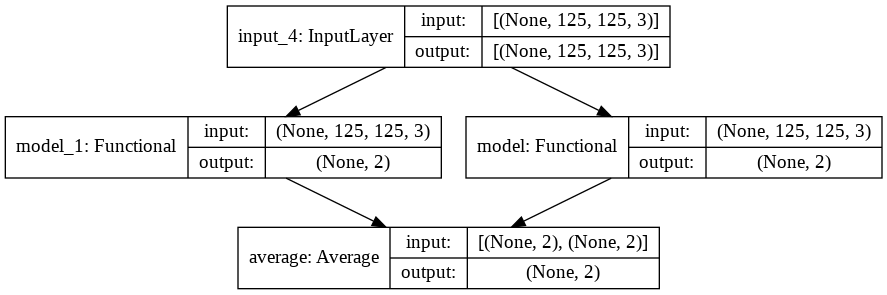

In [ ]:
tf.keras.utils.plot_model(ensemble_model, 'model.png', show_shapes= True)

## Train and test the CNN

Next, we call the fit method to optimize the model in 48 epochs, then perform predictions.

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1)
rd_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = np.sqrt(0.1), patience= 3, verbose = 1, min_lr = 5e-8)

history = ensemble_model.fit(train_dataset, epochs= 48, validation_data= validation_dataset,
                    verbose = 1, callbacks =[rd_lr,es])

Epoch 1/48
345/345 [==============================] - 118s 331ms/step - loss: 0.4628 - accuracy: 0.8426 - val_loss: 0.3002 - val_accuracy: 0.9365
Epoch 2/48
345/345 [==============================] - 113s 327ms/step - loss: 0.2577 - accuracy: 0.9204 - val_loss: 0.3199 - val_accuracy: 0.9289
Epoch 3/48
345/345 [==============================] - 112s 325ms/step - loss: 0.2254 - accuracy: 0.9253 - val_loss: 0.3212 - val_accuracy: 0.9442
Epoch 4/48
345/345 [==============================] - 114s 331ms/step - loss: 0.2304 - accuracy: 0.9197 - val_loss: 0.2380 - val_accuracy: 0.9514
Epoch 5/48
345/345 [==============================] - 114s 331ms/step - loss: 0.2085 - accuracy: 0.9320 - val_loss: 0.2999 - val_accuracy: 0.9438
Epoch 6/48
345/345 [==============================] - 114s 331ms/step - loss: 0.1870 - accuracy: 0.9384 - val_loss: 0.1763 - val_accuracy: 0.9550
Epoch 7/48
345/345 [==============================] - 115s 333ms/step - loss: 0.1916 - accuracy: 0.9362 - val_loss: 0.1524 -

Using the history object, we plot the validation accuracy and loss across the epochs to see how our models coverged.

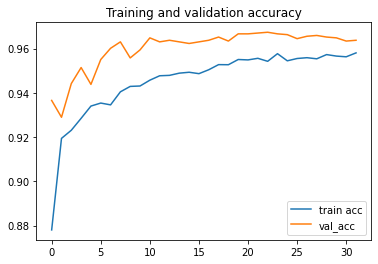

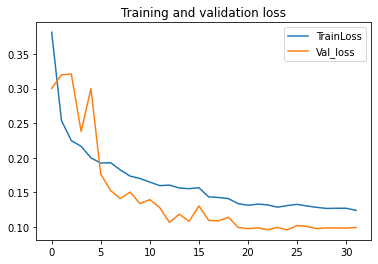

In [ ]:
# %% Check Plots
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label = 'train acc' )
plt.plot  ( epochs, val_acc, label = 'val_acc' )
plt.title ('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy Graph Ensemble Tuned')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label = 'TrainLoss' )
plt.plot  ( epochs, val_loss, label = 'Val_loss' )
plt.title ('Training and validation loss'   )
plt.savefig('Loss Graph Ensemble Tuned')
plt.legend()

plt.show()

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = ensemble_model.predict(test_generator,steps = nb_samples)
predictions = predict.argmax(axis = 1)
true_labels = test_generator.classes

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
 

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

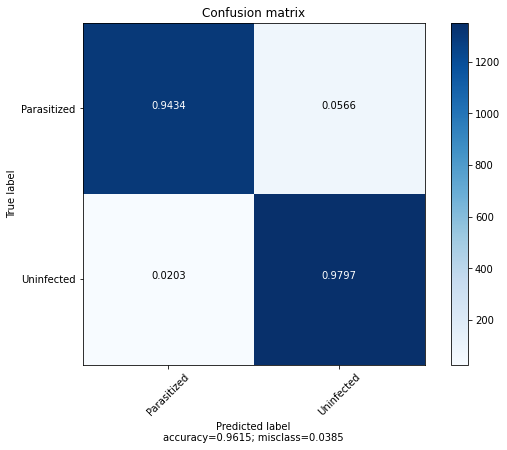

In [ ]:
cm = sklearn.metrics.confusion_matrix(true_labels, predictions)
target_names = ['Parasitized', 'Uninfected']
plot_confusion_matrix(cm,target_names)

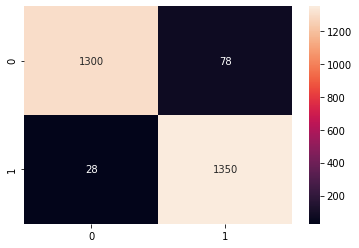

In [ ]:
sns.heatmap(cm, annot = True, fmt = 'd')

We measure our prediction accuracy using the classification_report function, which gives us the key classification metrics. I will also display those metrics individually so you can know their formulas.

- Precision: ability of the classifier not to label as positive a sample that is negative.
- Recall: the ability of the classifier to find all the positive samples
- F1: weighted average of the precision and recall

In [ ]:
print(classification_report(true_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.98      0.94      0.96      1378
  Uninfected       0.95      0.98      0.96      1378

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756

